In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.optimize as opt
from scipy.optimize import curve_fit
import math
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 150  # Set the figure dpi to 100 globally
plt.rcParams['font.family'] = 'serif' #Change font to Times New Roman
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Directed Percolation

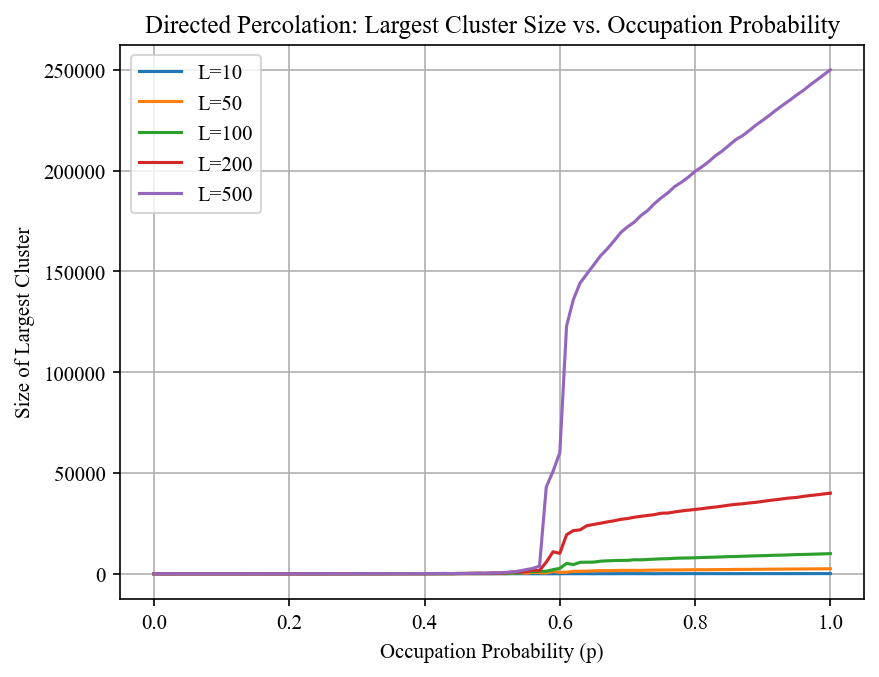

CPU times: total: 7.45 s
Wall time: 22.4 s


In [20]:
%%time

@njit  # This is a decorator indicating that the function should be compiled with Numba for faster execution
def simulate_dp(L_size, prob):
    # Initialize the lattice grid with random values based on the occupation probability
    lattice_grid = np.random.rand(L_size, L_size) < prob
    visited_nodes = np.zeros((L_size, L_size), dtype=np.bool_)  # Initialize a grid to track visited nodes
    
    def explore_cluster(i, j):
        # Recursive function to explore a cluster starting from position (i, j)
        stack = [(i, j)]  # Initialize a stack with the starting position
        size = 0  # Initialize the size of the cluster
        while stack:  # Continue as long as the stack is not empty
            x, y = stack.pop()  # Pop the last element from the stack
            # Check if the position is within bounds and not visited yet and if it's occupied
            if 0 <= x < L_size and 0 <= y < L_size and not visited_nodes[x, y] and lattice_grid[x, y]:
                visited_nodes[x, y] = True  # Mark the node as visited
                size += 1  # Increment the cluster size
                # Add neighboring nodes to the stack for exploration
                stack.extend([(x+1, y), (x-1, y), (x, y+1), (x, y-1)])
        return size  # Return the size of the explored cluster
    
    cluster_sizes = []  # Initialize a list to store cluster sizes
    # Loop through all nodes in the lattice grid
    for i in range(L_size):
        for j in range(L_size):
            # Check if the node is unvisited and occupied, then explore the cluster starting from this node
            if not visited_nodes[i, j] and lattice_grid[i, j]:
                size = explore_cluster(i, j)
                cluster_sizes.append(size)  # Append the size of the explored cluster
    
    return max(cluster_sizes) if cluster_sizes else 0  # Return the largest cluster size or 0 if no clusters exist

L_sizes = [10, 50, 100, 200, 500]  # List of lattice sizes to simulate
prob_values = np.linspace(0, 1, 101)  # Array of occupation probabilities from 0 to 1 with 101 values

for L_size in L_sizes:
    # Simulate directed percolation for each lattice size and occupation probability, then plot the results
    largest_clusters = [simulate_dp(L_size, prob) for prob in prob_values]
    plt.plot(prob_values, largest_clusters, label=f'L={L_size}')  # Plot largest cluster sizes vs. occupation probability

# Simulate directed percolation and calculate largest cluster sizes for each lattice size
largest_clusters_dict = {}
for L_size in L_sizes:
    largest_clusters = np.array([simulate_dp(L_size, prob) for prob in prob_values])
    largest_clusters_dict[f'L={L_size}'] = largest_clusters  # Store largest cluster sizes in a dictionary

# Plot settings and labels
plt.xlabel('Occupation Probability (p)')
plt.ylabel('Size of Largest Cluster')
plt.title('Directed Percolation: Largest Cluster Size vs. Occupation Probability')
plt.legend()
plt.grid(True)
plt.show()  # Display the plot

# Bak-Sneppen Model

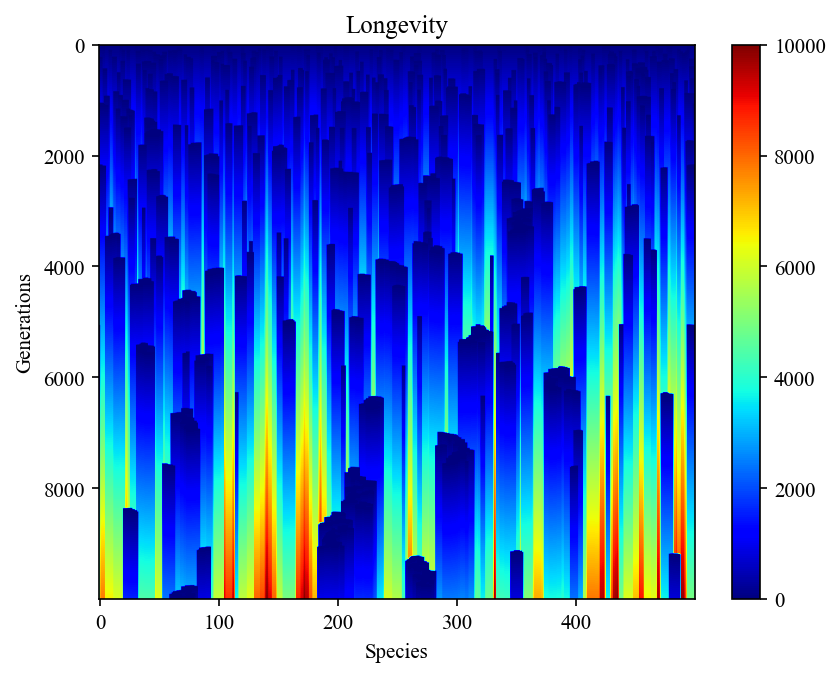

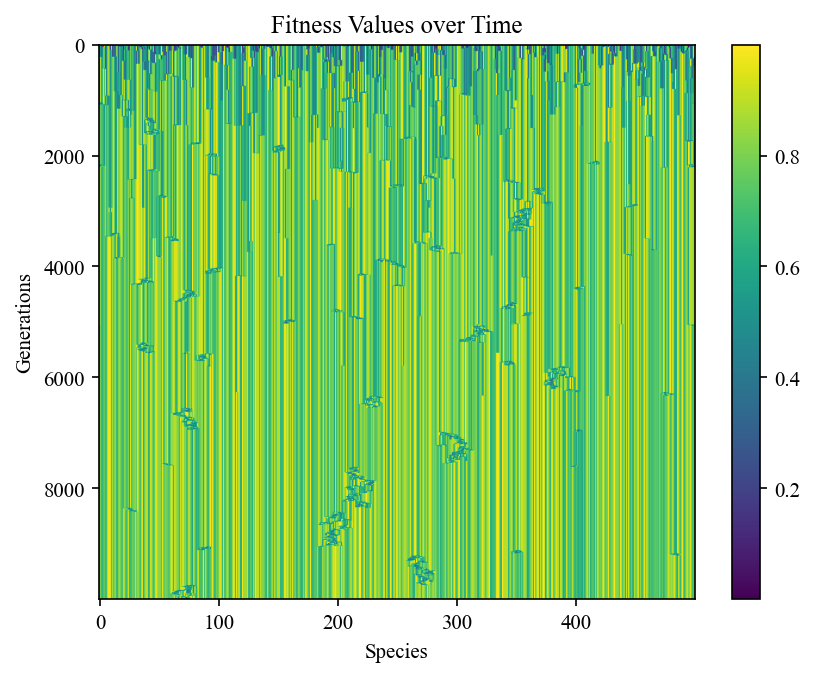

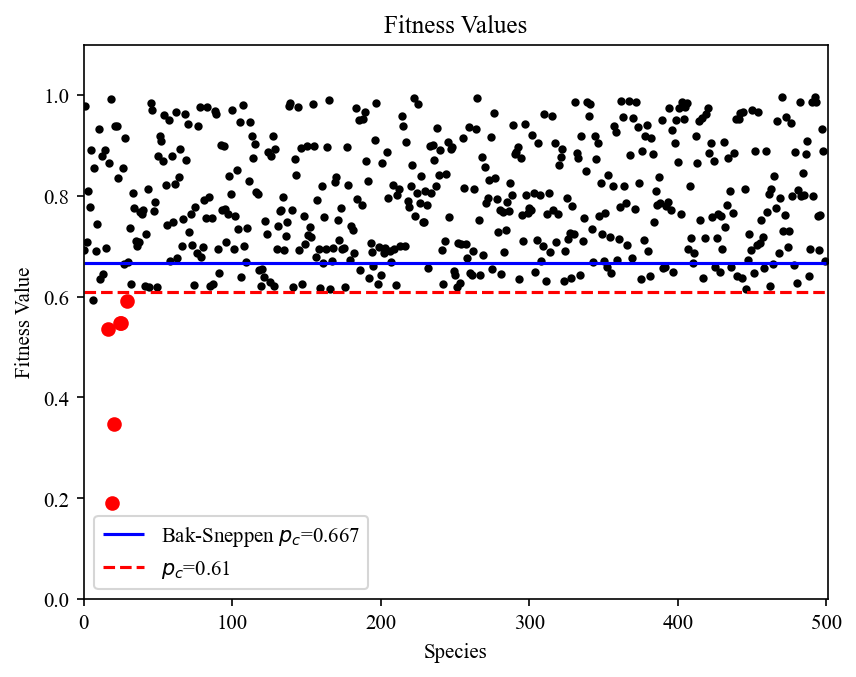

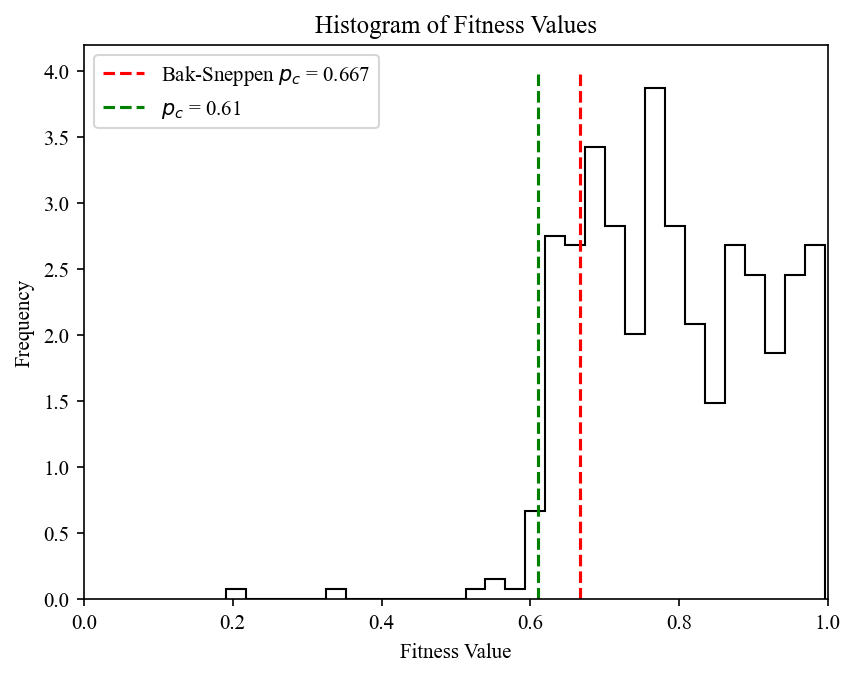

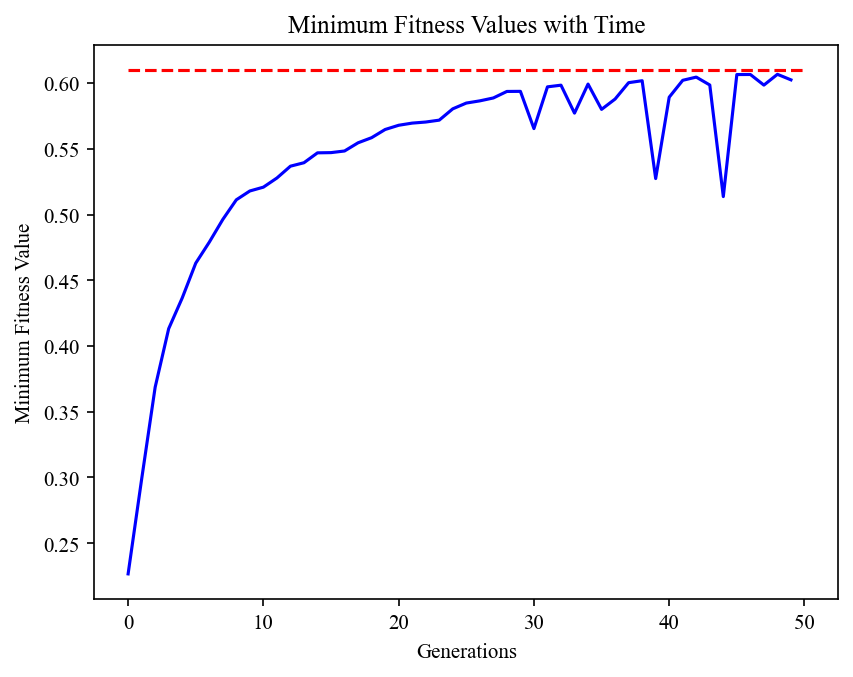

In [53]:
def simulate_bak_sneppen(population_size, max_generations, min_values, neighbor_size=2, neighbor_prob=1):
    """
    Simulates the Bak-Sneppen algorithm.

    Inputs:
        population_size : Size of population [int]
        max_generations : Maximum number of generations [int]
        neighbor_size : Size of neighbor species to be eliminated [int, default=2]
        neighbor_prob : Probability that neighbor is eliminated [int, default=1]

    Outputs:
        [mean_values, ages_start, ages_end, fitness_values, min_values]
    
    """
    # Initialize variables
    age_limit = 10000
    ages = np.zeros(population_size)
    ages_start = np.zeros((age_limit, population_size))
    ages_end = np.zeros((age_limit, population_size))

    mean_values = np.zeros(max_generations)       
    fitness_values = np.zeros((max_generations, population_size))  # Matrix to store fitness values
    b_values = np.random.rand(population_size)  # Initial random fitness values
    prob_p1 = 1

    for generation in range(max_generations):  # Loop over generations
        ages += 1  # Increase age of all species
        
        if np.random.random(1) < prob_p1:  # Check if a random event occurs
            idx_min_b = np.argmin(b_values)  # Find the index of the least fit species  
            min_b = np.min(b_values)  # Get the minimum fitness value
            min_values = np.append(min_values, min_b)  # Add the minimum fitness to the list

            b_values[idx_min_b] = np.random.random(1)  # Set a new random fitness value for the least fit species
            ages[idx_min_b] = 0  # Reset the age of the least fit species

        for d in range(1, 1+math.floor(neighbor_size / 2)):  # Loop over neighbor sizes
            if np.random.random(1) < neighbor_prob:  # Check if a neighbor is eliminated
                b_values[(idx_min_b + d) % population_size] = np.random.random(1)  # Set random fitness for the neighbor
                ages[(idx_min_b + d) % population_size] = 0  # Reset neighbor's age
            if np.random.random(1) < neighbor_prob:  # Check if another neighbor is eliminated
                b_values[(idx_min_b - d) % population_size] = np.random.random(1)  # Set random fitness for the neighbor
                ages[(idx_min_b - d) % population_size] = 0  # Reset neighbor's age

        mean_values[generation] = np.mean(b_values)  # Calculate mean fitness for the generation
        fitness_values[generation] = b_values  # Store fitness values for the generation

        if generation < age_limit:  # Store ages at the start of simulation
            for i in range(population_size):
                ages_start[generation, i] = ages[i]  

        if max_generations - generation < age_limit:  # Store ages at the end of simulation
            for i in range(population_size):
                ages_end[generation-max_generations, i] = ages[i]
                
    return [mean_values, ages_start, ages_end, fitness_values, min_values]

if __name__ == '__main__':
    j = 0
    data = [[]]

    # Simulate Bak-Sneppen model
    for i in range(0, 1):  # Loop for simulation
        population_size, max_generations = 500, 10000  # Set population size and max generations
        min_values = []  # Initialize list for minimum fitness values
        [mean_values, ages_start, ages_end, fitness_values, min_values] = simulate_bak_sneppen(population_size, max_generations, min_values)
        data[int(j)] = b_values  # Store fitness values
        j += 1

    data_mean_b_values = np.average(data, axis=0)  # Calculate average fitness values

    # Plotting
    plt.imshow(ages_start, aspect='auto', cmap="jet")  # Plot age at start
    plt.xlabel('Species')
    plt.ylabel('Generations')
    plt.title('Longevity')
    plt.colorbar()
    plt.show()
    
    plt.imshow(fitness_values, aspect='auto', cmap='viridis')  # Plot fitness values over time (transpose for correct orientation)
    plt.xlabel('Species')
    plt.ylabel('Generations')
    plt.title('Fitness Values over Time')
    plt.colorbar()
    plt.show()

    plt.plot(b_values, "k.")  # Plot fitness values
    plt.hlines(2/3, 0, population_size, color='b', label='Bak-Sneppen $p_c$=0.667')  # Horizontal line at 2/3 fitness value
    plt.hlines(0.61, 0, population_size, color='r',linestyle="dashed", label='$p_c$=0.61')  # Horizontal line at 2/3 fitness value
    plt.xlim(0, population_size+1)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.xlabel("Species")
    plt.ylabel("Fitness Value")
    plt.title('Fitness Values')

    # Mark the 4-5 least fit species in red
    sorted_indices = np.argsort(b_values)[:6]  # Get indices of 6 least fit species
    for idx in sorted_indices:
        plt.plot(idx, b_values[idx], 'ro')  # Mark the species in red

    plt.show()

    plt.hist(data_mean_b_values, bins=30, density=True, histtype="step", color="k")  # Plot histogram of average fitness values
    #plt.hist(min_values, bins=30, density=True, histtype="step", color="b", label='minimum fitness values')
    plt.ylabel("Frequency")
    plt.xlabel("Fitness Value")
    plt.xlim(0, 1)
    plt.vlines(0.667, 0, 4, "r", linestyle="dashed", label="Bak-Sneppen $p_c$ = 0.667")
    plt.vlines(0.61, 0, 4, "g", linestyle="dashed", label="$p_c$ = 0.61")
    plt.legend()
    plt.title('Histogram of Fitness Values')
    plt.show()

    plt.plot([max(a) for a in np.array_split(min_values, len(min_values) // 200)], color='b')  # Plot minimum fitness values over time
    plt.hlines(0.61, 0, len(min_values) // 200, color='r', linestyle='--')  # Add a horizontal line at y = 0.61
    plt.xlabel('Generations')
    plt.ylabel('Minimum Fitness Value')
    plt.title('Minimum Fitness Values with Time')
    plt.show()
